# Imports

In [1]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import plotnine as p9
import scipy
import sys

sys.path.insert(0, "./lib")

from lib.networkgen import Network, NetworkType
from lib.model import ModelWrapper
from lib.modelgen import Model, SIRModel, SEIZModel, SEIZplusModel, SEIZMModel, MoneyAgent
ModelType = Model.ModelType

# Initial Parameters

In [2]:
 # TODO: Simulation parameters

params = {
    ModelType.SIR: { # TODO
        'model': SIRModel.Params(
            initial_infected=0.01,
            initial_disagree=0.01,
            p_opinion_change=0.05
        ),
        'agent': None,
        'state_labels': [("Unsure", 'cornflowerblue'), ("Disagree","green"), ("Believe",'red')]
    },
    ModelType.SEIZ: { # TODO
        'model': SEIZModel.Params(
            initial_infected=0.01,
            initial_skeptics=0.01,
            prob_S_with_I=0.003,
            prob_S_with_Z=0.01,
            prob_E_to_I=0.001
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },
    ModelType.SEIZplus: {
        'model': SEIZplusModel.Params(
            initial_infected=0.05,
            initial_skeptics=0.02,
            prob_S_with_I=0.3,
            prob_S_with_Z=0.2,
            neighbor_threshold=0.7
        ),
        'agent': None,
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    },
    ModelType.SEIZM: { # TODO
        'model': SEIZMModel.Params(
            initial_infected = 0.1,
            initial_skeptics = 0.05,
            prob_S_with_I = 0.1,
            prob_S_with_Z = 0.2,
            certainty_threshold = 0.3,
            influence_threshold = 0.3,
            money_theshold = 0.3,
            influence_increase = 0.1,
            certainty_increase = 0.1,
            neighbor_threshold = 0.8
        ),
        'agent': MoneyAgent.Params(
            0.5,    # certainty
            0.5,    # influence
            0,      # money
            0.5     # sentiment
        ),
        'state_labels': [("Susceptible", 'cornflowerblue'), ("Exposed", "orange"), ("Skeptic","green"), ("Infected",'red')]
    }
}

network_params = {
    # Parameters are chosen such that all networks have similar density
    NetworkType.CAVEMAN: (10, 10),  # (l, k)
    NetworkType.WINDMILL: (10, 11),  # (n, k)
    NetworkType.SMALLWORLD: (),
    NetworkType.GAUSSIAN_RANDOM_PARTITION: (100, 5, 10, 0.3, 0.1),  # (n, s, v, p_in, p_out)
    NetworkType.BARABASI_ALBERT: (100, 20, 80, 0.85)  # (n, m1, m2, p)
}

# Helper functions

In [3]:
# TODO: Model Generation

def create_model(dynamics, network):
    # dynamics = ModelType.SEIZplus
    # network = NetworkType.CAVEMAN

    model = ModelWrapper(
        model_type=dynamics,
        model_params=params[dynamics]['model'],
        agent_params=params[dynamics]['agent'],
        network_type=network,
        network_params=network_params[network]
    )

    return model

In [4]:
# TODO: Uncertainty Plot

#convenience function to collect plotable data

def sum_agents(model, state_labels):
    agent_data = model.data_collector().get_agent_vars_dataframe()

    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
    # relabel
    labels = [l[0] for l in state_labels]
    agents_summed.columns = labels
    return agents_summed

def run_replicates(new_model, state_labels, n_replicates, n_steps):

    for i in tqdm(range(n_replicates), desc="Run"):

        #(re-)initiate model
        model = new_model()

        #run model
        model.run(n_steps)

        #data collection
        if i == 0:
            replicates = sum_agents(model, state_labels)
        else:
            replicates = pd.concat([replicates, sum_agents(model, state_labels)])

    #calculate means and standard error of the mean
    replicates = pd.pivot_table(replicates, index = ["Step"], aggfunc = [np.mean, scipy.stats.sem])

    return replicates

def plot_trajectories(data, colors_ggplot):
    # data wrangling for ggplot
    data = data.stack(level=1).reset_index(1).rename(columns={"level_1": "Population"}).sort_values("Population")
    data.reset_index(inplace=True)
    data = data.rename(columns = {'index':'Step'})

    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'Step', y = "mean", fill = "Population", group = "Population", color = "Population"))
    + p9.geom_line()
    + p9.geom_ribbon(p9.aes(x = 'Step', ymin = data["mean"] - data["sem"], ymax = data["mean"] + data["sem"]), outline_type = "none", alpha = 0.25, show_legend = False)
    + p9.ylab("Population size")
    + p9.xlab("Step")
    + p9.scale_color_manual(values = colors_ggplot)
    + p9.scale_fill_manual(values = colors_ggplot)
    + p9.ylim(0, max(data['mean']))
    + p9.theme_classic()
    )

    plot.draw(show=True)

    return plot

In [5]:
# TODO: (Graph snapshots), optional

In [6]:
# TODO: Phase Diagram

# Simulation Runs

In [7]:
def run(dynamics, network):
    df = run_replicates(
        lambda: create_model(dynamics, network),
        state_labels=params[dynamics]['state_labels'],
        n_replicates=10,
        n_steps=100)

    plot_trajectories(df, {label: color for label, color in params[dynamics]['state_labels']})

Run: 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


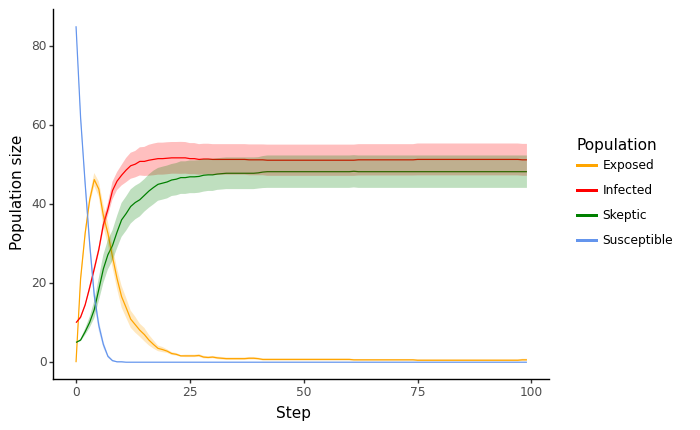

Run: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [10]:
dynamics, network = ModelType.SEIZM, NetworkType.GAUSSIAN_RANDOM_PARTITION  # by changing those two parameters you can set model dynamics and network topology
for i in range(20):
    params[dynamics]['model'] = SEIZMModel.Params(
            initial_infected = 0.1,
            initial_skeptics = 0.05,
            prob_S_with_I = 0.1,
            prob_S_with_Z = 0.1,
            certainty_threshold = i/20,
            influence_threshold = 0.3,
            money_theshold = 0.3,
            influence_increase = 0.1,
            certainty_increase = 0.1,
            neighbor_threshold = 0.8
        )

    run(dynamics, network)

Run:: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


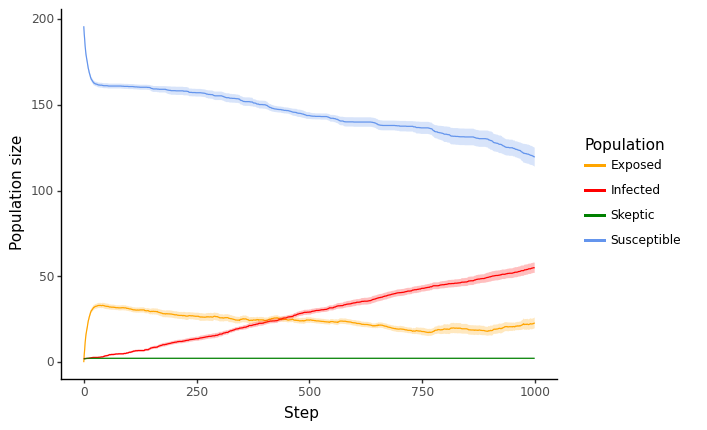

In [27]:
dynamics, network = ModelType.SEIZ, NetworkType.CAVEMAN # by changing those two parameters you can set model dynamics and network topology

run(dynamics, network)

Run: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


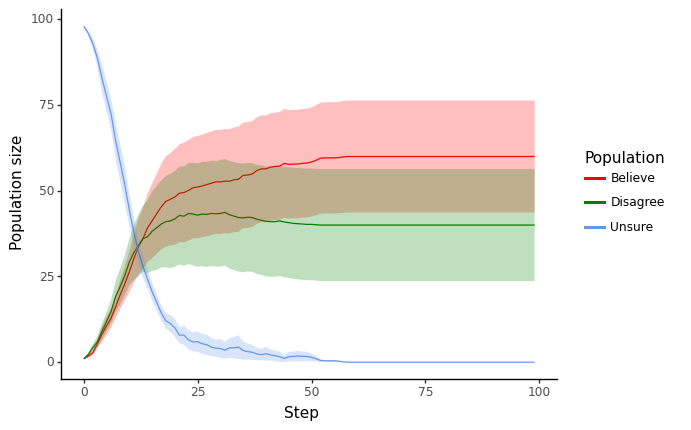

In [11]:
dynamics, network = ModelType.SIR, NetworkType.GAUSSIAN_RANDOM_PARTITION # by changing those two parameters you can set model dynamics and network topology

run(dynamics, network)